#**Variational Autoencoding**

Variational Autoencoders belongs to the general family of Autoencoders but are less similar to the apporaches we came across in earlier steps of this topic. Before we move on, it might be worthwhile looking at this [YouTube video](https://www.youtube.com/watch?v=9zKuYvjFFS8&vl=en). It will gives a nice recap of Autoencoders and gives a good description of Variational Autoencoders. Alternatively, if you are really struggling with the whole concept of autoencoders have a look at this article from [Towards Data Science](https://towardsdatascience.com/the-variational-autoencoder-as-a-two-player-game-part-i-4c3737f0987b). It is nice intuative apporach to the whole area.

In the first autoencoder example in M3.3.4, we mapped the orignal data back to itself through a *fixed* function. We did this to try and reduce the dimensionality of our dataset and to reduce noise, as shown in the previous step.  The mapping can be shown as follows:
>> $X->f(x)->X'$

where $f(X)$ is a reduced feature set of the orignal $X$.

Notice how the latent variables have fixed values(these atributes are fictional) and how "regimented" this process is. If we put a new image into the autoencoder we would get fixed values from the $f(X)$ function.   In fact it will only really work with the dataset that we have and will not really create realistic features if new data is introduced. In a way what we are looking for is smooth latent state representations of the input data. The following 2 figures try to highlight the differences between regular autoencoders and variational autoencoders. They are taken from a blog by [Jeremy Jordon](https://www.jeremyjordan.me/variational-autoencoders/) and hopefully will give you an intuitive interpretation of the difference between them. Now if you look at Figure 1 you will see that from the image inputted you will get a latent feature with a fixed value.

![var](https://www.computing.dcu.ie/~amccarren/mcm_images/autoencoder_3.png)
Figure 1: A typical blocked layer interpretation of a convolutional autoencoder.

Now intuitively if you or I were looking at this picture we might score the smile with a value but with some variation. So we might say this is a smile score of $\bar{x} \pm \sigma$. In Figure 2 we can see there are varing sureties of the degree of smile occuring.

![var](https://www.computing.dcu.ie/~amccarren/mcm_images/variaiotnal_autoencoder_2.png)
Figure 2: Probabiltiy distribution of a latent feature(smile)

So now we can create an encoder and decoder that have as the bottleneck not a fixed function but a probability distribution. Figure 3 shows how the introduction of a probablistic encoder gives a nice example of how an image goes through a typical variational encoder.

![var](https://www.computing.dcu.ie/~amccarren/mcm_images/variational_autoencoder.png)

Figure 2: [Variational Autoencoder Architecture](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)

Now, the benifits of this type of encoder are that it will not just create latent vectors but it will also allow you to fill in gaps or missing sections of data. It is a lot of similarities with Generative Adveserial Networks although the structures can be said to reversed. A VAE reduces its hidden features while GANs expand on them. According to Towards Data Science "a variational autoencoder can be defined as being an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process". So we now have a algoithm that can potentially generate content and could be considered as a missing value imputation technique.

The following code comes from github and was written by the Keras team. It was based on the orignal work from [Kingma, Diederik P., and Max Welling, "Auto-Encoding Variational Bayes."](
https://arxiv.org/abs/1312.6114) I have adapted it to work on google colab. You will notice I have commented the pieces out where arguments are expected from the command line.




**Note**
An isotropic gaussian is one where the covariance matrix is represented by the simplified matrix:
>> $\Sigma=\sigma^2I$.

Where $\Sigma$ a diaginal matrix and each diagonal element is equal to $\sigma$ implying tha all dimensions are independent.

In the first 2 code fragments we set up tensorflow version 2.x and we create sampling function and a plotting function. The idea of this code piece is to run a VAE which will have 2 latent features. These features will be plotted with the actual number color coded on the plot.

In [1]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()



Now we will

In [2]:
'''Example of VAE on MNIST dataset using MLP
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model

from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os





# MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Now we reshape the image to a flattened numpy array and build the VAE. We plot the encoder and the decoder. Note how the sampling function is called using Keras Lambda function.

In [3]:

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()



# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()



# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

#parser = argparse.ArgumentParser()
#help_ = "Load h5 model trained weights"
#parser.add_argument("-w", "--weights", help=help_)
#help_ = "Use mse loss instead of binary cross entropy (default)"
#parser.add_argument("-m","--mse", help=help_, action='store_true')
#args = parser.parse_args()
models = (encoder, decoder)
data = (x_test, y_test)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 784)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        401,920 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          1,026 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          1,026 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 403,972 (1.54 MB)

 Trainable params: 403,972 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 784)                 │         402,192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 403,728 (1.54 MB)

 Trainable params: 403,728 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.layers import Layer
reconstruction_loss = mse(inputs, outputs)
#reconstruction_loss = binary_crossentropy(inputs,outputs)

reconstruction_loss *= original_dim

class KLLossLayer(Layer):
    """
    Custom Keras layer to calculate the KL loss.
    """
    def __init__(self, **kwargs):
        super(KLLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)  # Use tf.square and tf.exp
        kl_loss = tf.reduce_sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        return kl_loss

# ... (rest of your code) ...

# Instantiate the custom layer
kl_loss_layer = KLLossLayer()

# Calculate the KL loss using the layer
kl_loss = kl_loss_layer([z_mean, z_log_var])
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

AttributeError: 'str' object has no attribute 'base_dtype'

The next thing we will do is fit the model. This is a very complicated model. I don't expect you to be able to understand the intricacies of it. Just try and grasp the fact the latent component is built on a proabablistic approach.




In [9]:

#vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))
#vae.save_weights('vae_mlp_mnist.h5')

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train)) # Assuming you want to reconstruct the input
train_dataset = train_dataset.batch(batch_size)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test))
validation_dataset = validation_dataset.batch(batch_size)

# Fit the model using the datasets
vae.fit(train_dataset,
        epochs=epochs,
        validation_data=validation_dataset)

vae.save_weights('vae_mlp_mnist.h5')

AttributeError: module 'tensorflow.python.distribute.input_lib' has no attribute 'DistributedDatasetInterface'

We are going to assign a color to each digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space). If you look at the plot function above you will see that the encoder is being used to generate the 2 features, $z[0]$ and $z[1]$. You can see that these 2 features really do describe the data pretty well.

79/79 [==============================] - 0s 2ms/step


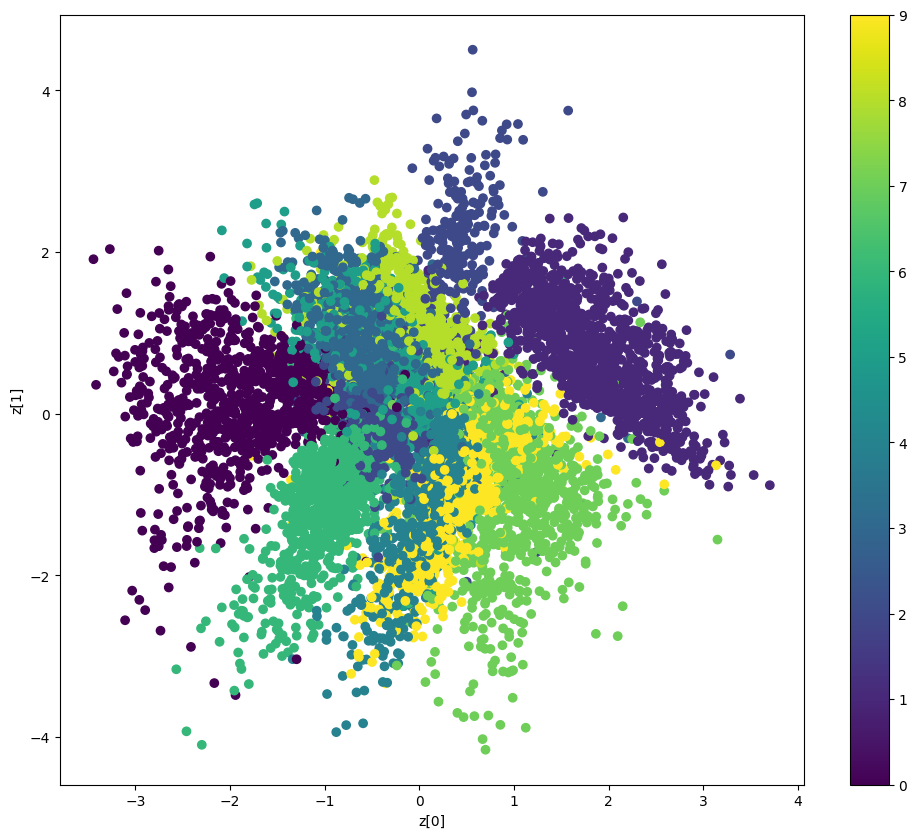

In [ ]:
plot_results(models,data,batch_size=batch_size,model_name="vae_mlp")



We have now finished this step and I would like you to experiment with the number of latent variables and see if the loss function reduces. Also experiment with the loss function. Don't forget to share your comments on the comments board.

If you want to generate new images go to the github page I mentioned earlier. The code is there and you will be able to generate brand new images.

